In [53]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [54]:
import numpy as np
import pandas as pd

In [55]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///../Instructions/Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

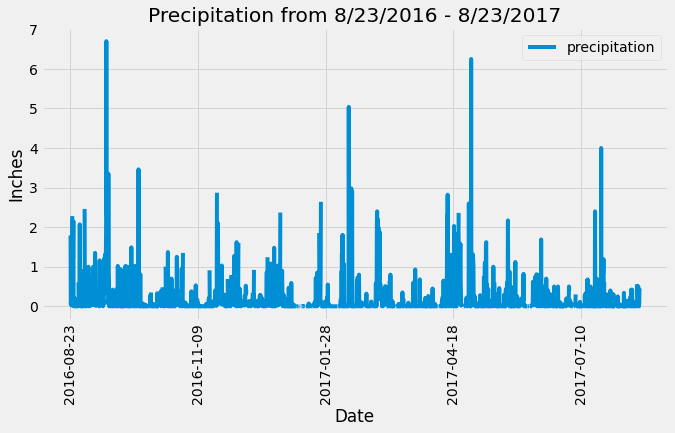

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

query_date = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrames, set the index to the date columns, sort the dataframe by date
prcp_df = pd.DataFrame(prcp, columns=['date', 'precipitation']).set_index('date').sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df['precipitation'].plot(figsize=(10,5), label='precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc='best')
plt.title("Precipitation from 8/23/2016 - 8/23/2017")
plt.xticks(rotation='vertical')

# And a corresponding grid
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.show()

In [11]:
# Use Pandas to calculale the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
#session.query(Station.station).count()
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station)\
        .desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
#Which station has the highest number of observations?
session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station)\
        .desc()).first()    

('USC00519281', 2772)

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
                
temp = session.query(Measurement.station, *sel).filter(Measurement.station == 'USC00519281').first()
print(f'For USC00519281: lowest temperature = {temp[1]}, highest temperature = {temp[2]}, average temperature = {temp[3]}')

For USC00519281: lowest temperature = 54.0, highest temperature = 85.0, average temperature = 71.66378066378067


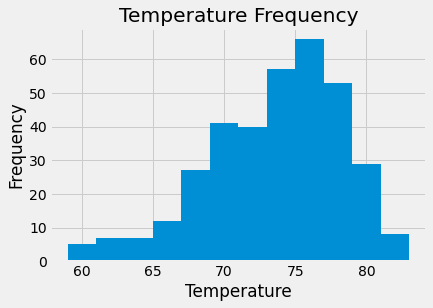

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# filter(Measurement.date >= query_date)
year_temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= query_date).all()
hist_temps_df = pd.DataFrame(year_temps)

plt.hist(hist_temps_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Frequency')
plt.show()



## Bonus Challenge Assignment

In [17]:
from scipy import stats
from numpy import mean

In [18]:
### Temperature Analysis I
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

june_str = "06"
june_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == june_str).all()

dec_str = "12"
dec_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == dec_str).all()

print(f" June Avg: {june_avg[0][0]}, Dec Avg: {dec_avg[0][0]}")


 June Avg: 74.94411764705882, Dec Avg: 71.04152933421226


In [19]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why? - unpaired t-test since unequal sample sizes

june_tobs = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "06")

june_list = []
for item in june_tobs:
    june_list.append(item.tobs)

dec_tobs = session.query(Measurement.tobs).\
     filter(func.strftime("%m", Measurement.date) == "12")

dec_list = []
for x in dec_tobs:
    dec_list.append(x.tobs)

stats.ttest_ind(dec_list, june_list)

Ttest_indResult(statistic=-31.60372399000329, pvalue=3.9025129038616655e-191)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2017-01-08'))

[(60.0, 68.27659574468085, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-01-01', '2017-01-08')
prev_trip = calc_temps('2016-01-01', '2016-01-08')
prev_trip

[(62.0, 69.91666666666667, 76.0)]

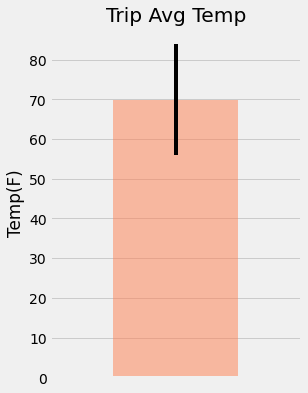

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title, use the average temperature for the y value, use the (tmax-tmin) value as the y error bar (yerr)
prev_trip_df = pd.DataFrame(prev_trip, columns = ["Tmin", "Tavg", "Tmax"])

error = prev_trip_df.iloc[0]['Tmax'] - prev_trip_df.iloc[0]['Tmin']

avg_temp = prev_trip_df['Tavg']

avg_temp.plot(kind='bar', yerr=error, figsize=(4,6), title = "Trip Avg Temp", color='coral', alpha=0.5)
plt.ylabel('Temp(F)')
plt.xticks([])
plt.show()


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [
    Station.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    Measurement.prcp,
    Measurement.date,    
]

rf = session.query(*sel).filter(Measurement.station == Station.station).\
filter(Measurement.date >= "2016-01-01").\
filter(Measurement.date <= "2016-01-08").all()


rf_df = pd.DataFrame(rf).dropna()
rainfall_df = rf_df.groupby(['station', 'name', 'latitude', 'longitude', 'elevation'])['prcp'].sum().reset_index()
rainfall_df.sort_values('prcp', ascending=False)


,station,name,latitude,longitude,elevation,prcp
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.94
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.95
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.56
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.19
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.13


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = dt.date(2017,1,1)
trip_end = dt.date(2017,1,8)

# Use the start and end date to create a range of dates
# cite:  https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
trip_dates = pd.date_range(start="2017-01-01",end="2017-01-08")
 
# Strip off the year and save a list of %m-%d strings
range_str = [dt.datetime.strftime(trip_end - dt.timedelta(days = x), '%m-%d')
             for x in range(0, 8)]

# calculate normals for each date
# Loop through the list of %m-%d strings and calculate the normals for each date
daily = [daily_normals(date) for date in range_str]
normals = []   
for result in daily:
        normals_dict = {}
        normals_dict['TMIN'] = result[0][0]
        normals_dict['TAVG'] = result[0][1]
        normals_dict['TMAX'] = result[0][2]
        normals.append(normals_dict)
normals

[{'TMIN': 57.0, 'TAVG': 67.16071428571429, 'TMAX': 75.0},
 {'TMIN': 57.0, 'TAVG': 68.54385964912281, 'TMAX': 76.0},
 {'TMIN': 61.0, 'TAVG': 68.96491228070175, 'TMAX': 76.0},
 {'TMIN': 56.0, 'TAVG': 67.96428571428571, 'TMAX': 76.0},
 {'TMIN': 58.0, 'TAVG': 70.0, 'TMAX': 76.0},
 {'TMIN': 62.0, 'TAVG': 68.9090909090909, 'TMAX': 77.0},
 {'TMIN': 60.0, 'TAVG': 69.39622641509433, 'TMAX': 77.0},
 {'TMIN': 62.0, 'TAVG': 69.15384615384616, 'TMAX': 77.0}]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, trip_dates).rename_axis('Dates')
normals_df

,TMIN,TAVG,TMAX
Dates,,,
2017-01-01,57.0,67.160714,75.0
2017-01-02,57.0,68.543860,76.0
2017-01-03,61.0,68.964912,76.0
2017-01-04,56.0,67.964286,76.0
2017-01-05,58.0,70.000000,76.0
2017-01-06,62.0,68.909091,77.0
2017-01-07,60.0,69.396226,77.0
2017-01-08,62.0,69.153846,77.0


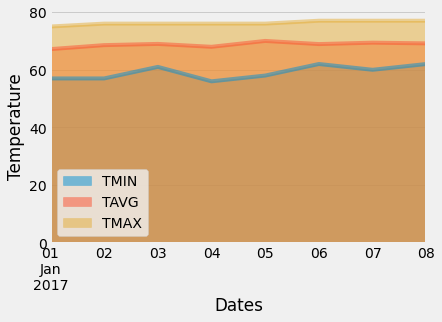

In [58]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.ylabel('Temperature')
plt.show()
